#  Chapter 5, demo 1

Bayesian Data Analysis, 3rd ed

Hierarchical model for Rats experiment (BDA3, p. 102).

In [1]:
from scipy.stats import beta
from scipy.special import gammaln

import numpy as np
import matplotlib.pyplot as plt
import preliz as pz
pz.style.use('preliz-doc')

In [2]:
# rat data (BDA3, p. 102)
y = np.array([
     0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
     1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  5,  2,
     5,  3,  2,  7,  7,  3,  3,  2,  9, 10,  4,  4,  4,  4,  4,  4,  4,
    10,  4,  4,  4,  5, 11, 12,  5,  5,  6,  5,  6,  6,  6,  6, 16, 15,
    15,  9,  4
])
n = np.array([
    20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 18, 18, 17, 20, 20, 20,
    20, 19, 19, 18, 18, 25, 24, 23, 20, 20, 20, 20, 20, 20, 10, 49, 19,
    46, 27, 17, 49, 47, 20, 20, 13, 48, 50, 20, 20, 20, 20, 20, 20, 20,
    48, 19, 19, 19, 22, 46, 49, 20, 20, 23, 19, 22, 20, 20, 20, 52, 46,
    47, 24, 14
])
M = len(y)

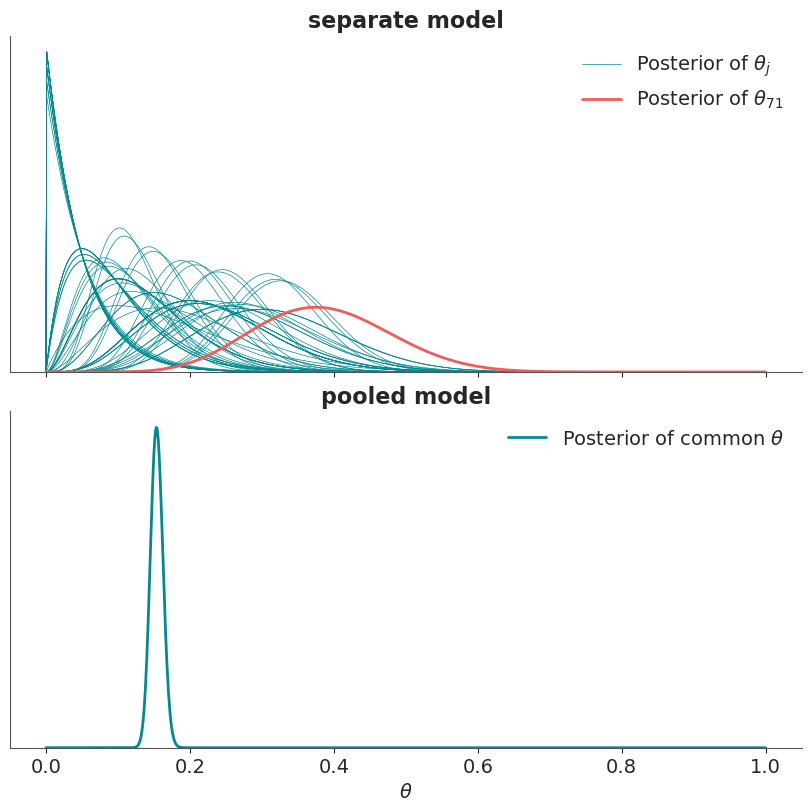

In [3]:
fig, (ax_sep, ax_pool) = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
x = np.linspace(0, 1, 1000)

# Separate model
lines = ax_sep.plot(
    x,
    pz.Beta(y[:-1] + 1, n[:-1] - y[:-1] + 1).pdf(x[:, None]),
    color="C0",
    lw=0.5
)
# highlight last line
lines[-1].set(lw=2, color="C2")

ax_sep.legend(
    [lines[0], lines[-1]],
    [r"Posterior of $\theta_j$", r"Posterior of $\theta_{71}$"]
)

ax_sep.set(ylim=0, yticks=[], title="separate model")

# Pooled model
ax_pool.plot(
    x,
    pz.Beta(y.sum() + 1, n.sum() - y.sum() + 1).pdf(x),
    lw=2,
    label=r"Posterior of common $\theta$"
)
ax_pool.legend()
ax_pool.set(ylim=0, yticks=[], xlabel=r"$\theta$", title="pooled model");

In [4]:
# compute the marginal posterior of alpha and beta in the hierarchical model in a grid
A = np.linspace(0.5, 6, 100)
B = np.linspace(3, 33, 100)
# calculated in logarithms for numerical accuracy
lp = (
  - 5/2 * np.log(A + B[:,None])
  + np.sum(
        gammaln(A + B[:,None])
      - gammaln(A)
      - gammaln(B[:,None])
      + gammaln(A + y[:,None,None])
      + gammaln(B[:,None] + (n - y)[:,None,None])
      - gammaln(A + B[:,None] + n[:,None,None]),
        axis=0
    )
)
# subtract the maximum value to avoid over/underflow in exponentation
lp -= lp.max()
p = np.exp(lp)

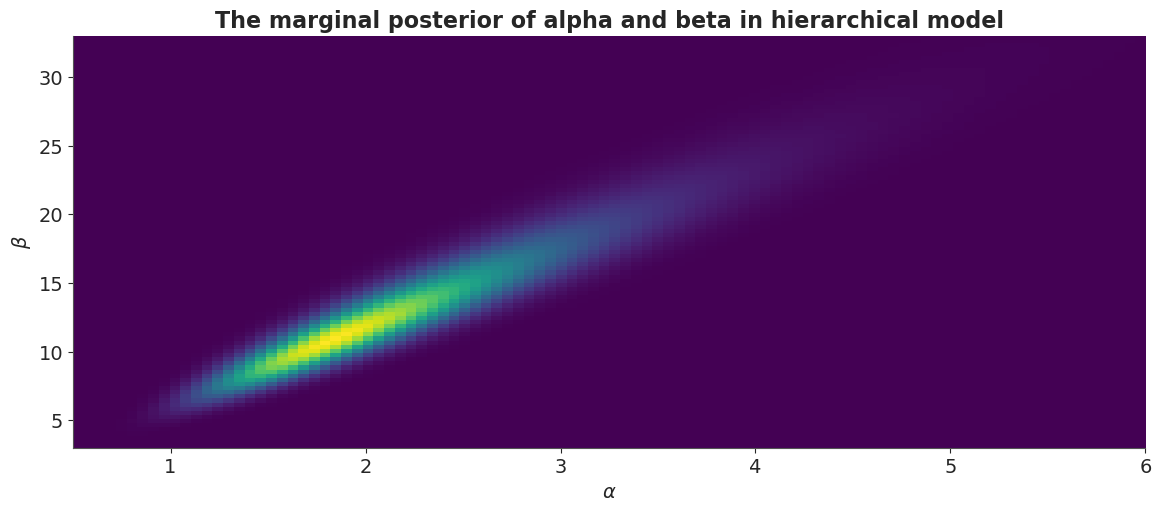

In [5]:
# plot the marginal posterior
_, ax = plt.subplots()
ax.imshow(
    p,
    origin='lower',
    aspect='auto',
    extent=(A[0], A[-1], B[0], B[-1])
)
ax.set(xlabel=r'$\alpha$', ylabel=r'$\beta$', title='The marginal posterior of alpha and beta in hierarchical model')
ax.grid(False)

In [6]:
# sample from the posterior grid of alpha and beta
nsamp = 1000
samp_indices = np.unravel_index(
    np.random.choice(p.size, size=nsamp, p=p.ravel()/p.sum()),
    p.shape
)
samp_A = A[samp_indices[1]]
samp_B = B[samp_indices[0]]
# add random jitter, see BDA3 p. 76
samp_A += (np.random.rand(nsamp) - 0.5) * (A[1]-A[0])
samp_B += (np.random.rand(nsamp) - 0.5) * (B[1]-B[0])

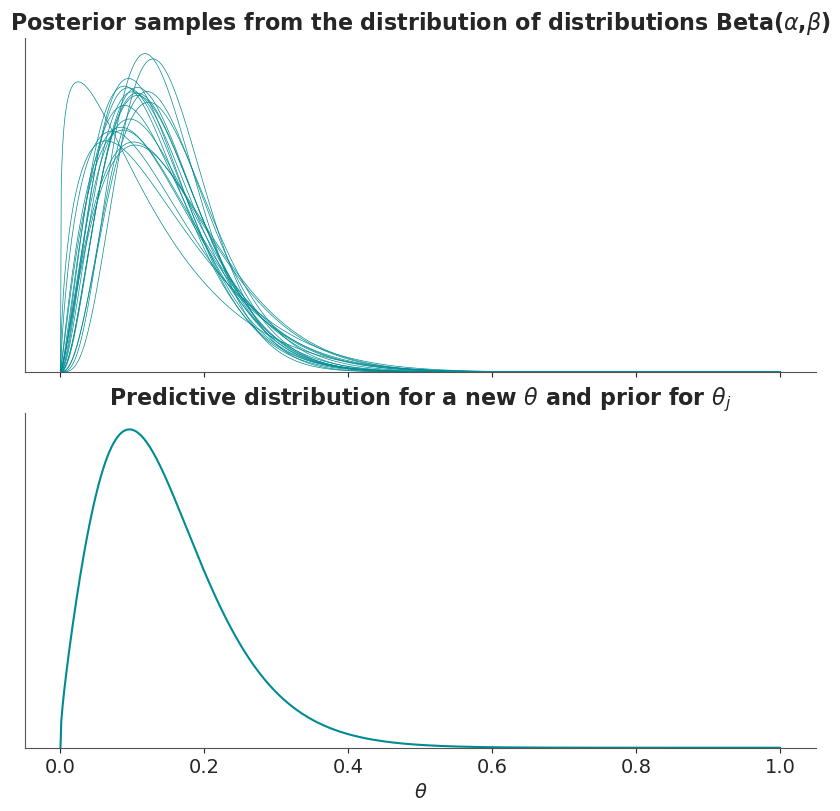

In [7]:
fig, (ax_samples, ax_pred) = plt.subplots(2, 1, sharex=True, figsize=(8, 8))

# Posterior samples from Beta(alpha, beta)
ax_samples.plot(
    x,
    beta.pdf(x[:, None], samp_A[:20], samp_B[:20]),
    lw=0.5, color="C0"
)
ax_samples.set(yticks=[], ylim=0,
               title=r'Posterior samples from the distribution of distributions Beta($\alpha$,$\beta$)')

# Predictive distribution for a new theta
mean_pdf = pz.Beta(samp_A[:, None], samp_B[:, None]).pdf(x).mean(axis=0)
ax_pred.plot(x, mean_pdf)
ax_pred.set(yticks=[], ylim=0,
            xlabel=r"$\theta$",
            title=r'Predictive distribution for a new $\theta$ and prior for $\theta_j$');

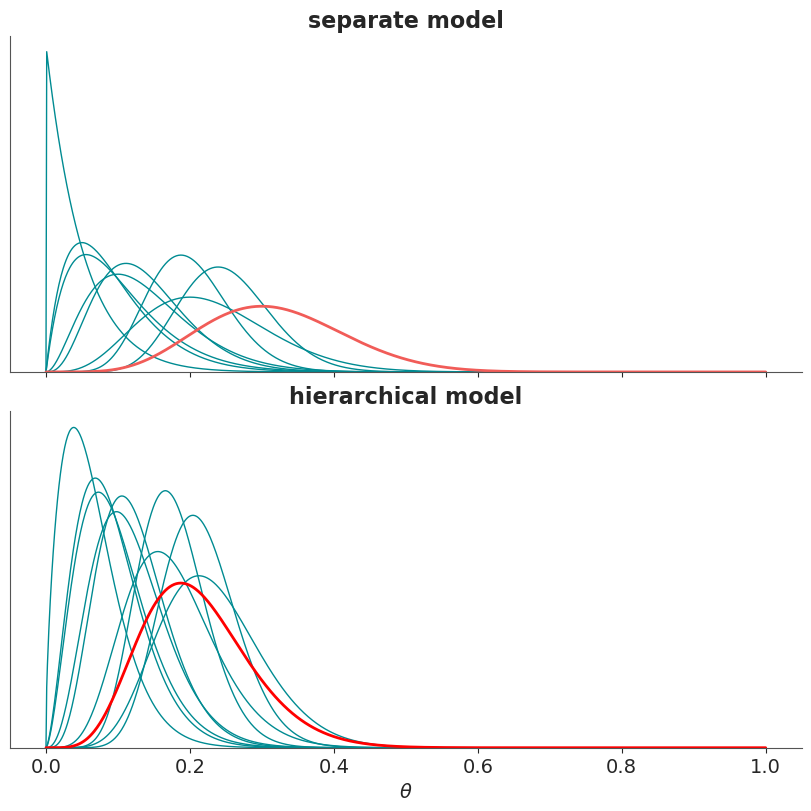

In [8]:
fig, (ax_sep, ax_hier) = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
x = np.linspace(0, 1, 1000)

# Separate model (plot every 7th distribution)
lines = ax_sep.plot(
    x,
    pz.Beta(y[7:-1:7] + 1, n[7:-1:7] - y[7:-1:7] + 1).pdf(x[:, None]),
    color="C0", lw=1
)
lines[-1].set(lw=2, color="C2")
ax_sep.set(yticks=[], ylim=0, title="separate model")

# Hierarchical model (plot every 7th distribution) ---
lines = ax_hier.plot(
    x,
    np.mean(pz.Beta(
            y[7::7] + samp_A[:,None,None],
            n[7::7] - y[7::7] + samp_B[:,None,None]
            ).pdf(x[:,None]), axis=0),
    color='C0', lw=1,
)
lines[-1].set(lw=2, color="r")
ax_hier.set(yticks=[], ylim=0, xlabel=r"$\theta$", title="hierarchical model");
